# Visualizations

This is a little notebook with some visual sanity checks.
Proper tests are in [tests/](./tests/).
This notebook is just to visually look at how the simulation behaves.

In [1]:
from itertools import product, combinations
import pandas as pd
import torch
from Levenshtein import distance
from plotnine import *
import magicsoup as ms
from magicsoup.constants import GAS_CONSTANT
from magicsoup.examples.wood_ljungdahl import CHEMISTRY, MOLECULES, REACTIONS

theme_set(theme_minimal())

## Genomes

In [2]:
def record_proteome_stats(proteomes: list[list[ms.ProteinSpecType]], records: list[dict], size: int, record: dict, dom_size: int):
    for proteome in proteomes:
        n_prots = len(proteome)
        records.append({
            **record,
            "n": n_prots,
            "v": "proteins/genome"
        })
        if n_prots > 0:
            n_doms = sum(len(d[0]) for d in proteome)
            records.append({
                **record,
                "n": n_doms / n_prots,
                "v": "domains/protein"
            })
            records.append({
                **record,
                "n": n_doms * dom_size / size,
                "v": "coding nts/nt"
            })

def get_proteome_stat_avgs(df: pd.DataFrame, by: str, pad_coding=0.5, pad_doms=0.5, pad_prots=10.0) -> pd.DataFrame:
    df["v"] = pd.Categorical(df["v"], categories=["proteins/genome", "domains/protein", "coding nts/nt"], ordered=True)
    avgs = df.groupby([by, "v"])["n"].median().reset_index()
    avgs["l"] = [f"{d:.1f}" for d in avgs["n"]]
    avgs.loc[:, "x"] = avgs["n"]
    avgs.loc[avgs["v"] == "coding nts/nt", "x"] += pad_coding
    avgs.loc[avgs["v"] == "domains/protein", "x"] += pad_doms
    avgs.loc[avgs["v"] == "proteins/genome", "x"] += pad_prots
    return avgs

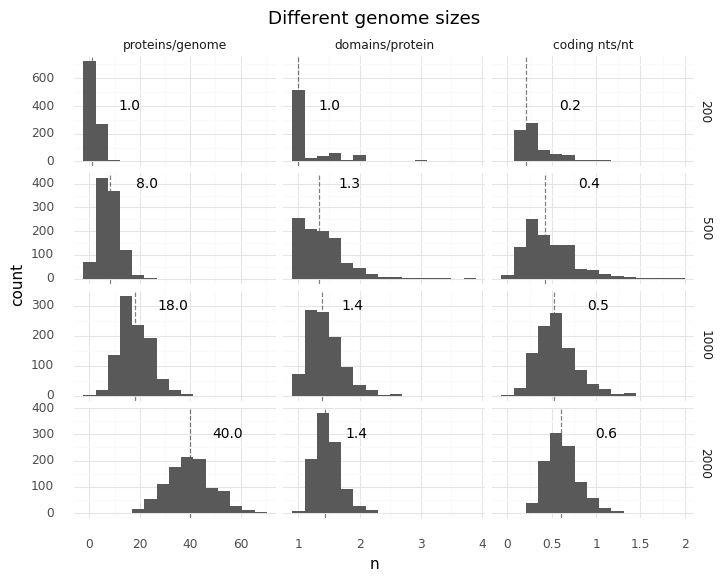

<ggplot: (8752205443436)>

In [3]:
records = []
for size in (200, 500, 1000, 2000):
    genetics = ms.Genetics()
    genomes = [ms.random_genome(s=size) for _ in range(1000)]
    proteomes = genetics.translate_genomes(genomes=genomes)
    record_proteome_stats(proteomes=proteomes, records=records, size=size, dom_size=genetics.dom_size, record={"size": size})
df = pd.DataFrame.from_records(records)

avgs = get_proteome_stat_avgs(df=df, by="size", pad_prots=15)
avgs.loc[avgs["size"] == 200, "y"] = 400
avgs.loc[avgs["size"] == 500, "y"] = 400
avgs.loc[avgs["size"] == 1000, "y"] = 300
avgs.loc[avgs["size"] == 2000, "y"] = 300

(ggplot(df)
    + geom_vline(aes(xintercept="n"), data=avgs, linetype="dashed", alpha=0.5)
    + geom_histogram(aes(x="n"), bins=15)
    + geom_text(aes(x="x", y="y", label="l"), data=avgs, size=10)
    + facet_grid("size ~ v", scales="free")
    + theme(figure_size=(8, 6))
    + ggtitle("Different genome sizes"))

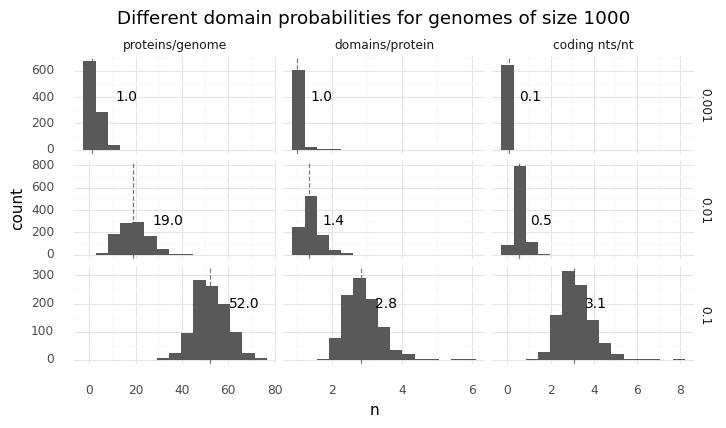

<ggplot: (8752199518311)>

In [4]:
size = 1000

records = []
for prob in (0.001, 0.01, 0.1):
    genetics = ms.Genetics(p_reg_dom=prob, p_catal_dom=prob, p_transp_dom=prob)
    genomes = [ms.random_genome(s=size) for _ in range(1000)]
    proteomes = genetics.translate_genomes(genomes=genomes)
    record_proteome_stats(proteomes=proteomes, records=records, size=size, dom_size=genetics.dom_size, record={"prob": prob})
df = pd.DataFrame.from_records(records)

avgs = get_proteome_stat_avgs(df=df, by="prob", pad_prots=15, pad_doms=0.7, pad_coding=1.0)
avgs.loc[avgs["prob"] == 0.001, "y"] = 400
avgs.loc[avgs["prob"] == 0.01, "y"] = 300
avgs.loc[avgs["prob"] == 0.1, "y"] = 200

(ggplot(df)
    + geom_vline(aes(xintercept="n"), data=avgs, linetype="dashed", alpha=0.5)
    + geom_histogram(aes(x="n"), bins=15)
    + geom_text(aes(x="x", y="y", label="l"), data=avgs, size=10)
    + facet_grid("prob ~ v", scales="free")
    + theme(figure_size=(8, 4))
    + ggtitle(f"Different domain probabilities for genomes of size {size}"))

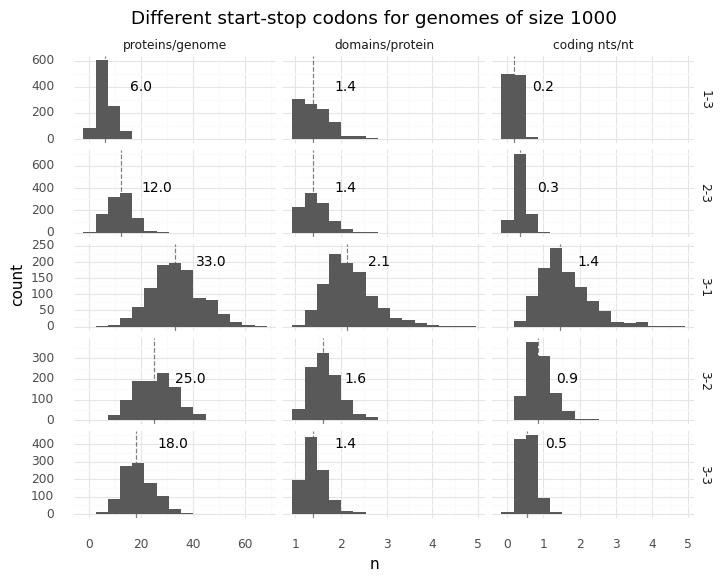

<ggplot: (8752204109858)>

In [5]:
kwargs_map = {
    "3-3": {},
    "2-3": {"start_codons": ("ATG", "GTG")},
    "1-3": {"start_codons": ("ATG", )},
    "3-2": {"stop_codons": ("TAG", "TAA")},
    "3-1": {"stop_codons": ("TAG", )}
}

records = []
for label, kwargs in kwargs_map.items():
    genetics = ms.Genetics(**kwargs)
    genomes = [ms.random_genome(s=size) for _ in range(1000)]
    proteomes = genetics.translate_genomes(genomes=genomes)
    record_proteome_stats(proteomes=proteomes, records=records, size=size, dom_size=genetics.dom_size, record={"start-stop": label})
df = pd.DataFrame.from_records(records)

avgs = get_proteome_stat_avgs(df=df, by="start-stop", pad_prots=14, pad_doms=0.7, pad_coding=0.8)
avgs.loc[avgs["start-stop"] == "1-3", "y"] = 400
avgs.loc[avgs["start-stop"] == "2-3", "y"] = 400
avgs.loc[avgs["start-stop"] == "3-1", "y"] = 200
avgs.loc[avgs["start-stop"] == "3-2", "y"] = 200
avgs.loc[avgs["start-stop"] == "3-3", "y"] = 400

(ggplot(df)
    + geom_vline(aes(xintercept="n"), data=avgs, linetype="dashed", alpha=0.5)
    + geom_histogram(aes(x="n"), bins=15)
    + geom_text(aes(x="x", y="y", label="l"), data=avgs, size=10)
    + facet_grid("start-stop ~ v", scales="free")
    + theme(figure_size=(8, 6))
    + ggtitle(f"Different start-stop codons for genomes of size {size}"))

## Transcriptomes

In [6]:
chemistry = ms.Chemistry(molecules=MOLECULES, reactions=REACTIONS)
world = ms.World(map_size=8, chemistry=chemistry)
world.spawn_cells(genomes=[ms.random_genome(s=1000) for _ in range(10)])


def plot_genome_transcripts(cell_idx: int, world: ms.World, title="", w=14, h=0.2, gw=5, cdsw=4) -> ggplot:
    cell = world.get_cell(by_idx=cell_idx)
    proteome = cell.get_proteome(world=world)
    n = len(cell.genome)

    dom_type_map = {ms.CatalyticDomain: "catal", ms.TransporterDomain: "trnsp", ms.RegulatoryDomain: "reg"}
    records = [{"tag": "genome", "dir": "", "start": 0, "stop": n, "type": "genome"}]
    for pi, prot in enumerate(proteome):
        tag = f"CDS{pi}"
        start = prot.cds_start if prot.is_fwd else n - prot.cds_start
        stop = prot.cds_end if prot.is_fwd else n - prot.cds_end
        records.append({
            "tag": tag,
            "dir": "fwd" if prot.is_fwd else "bwd",
            "start": start,
            "stop": stop,
            "type": "CDS"
        })
        for dom in prot.domains:
            records.append({
                "tag": tag,
                "dir": "fwd" if prot.is_fwd else "bwd",
                "start": start + dom.start if prot.is_fwd else start - dom.start,
                "stop": start + dom.end if prot.is_fwd else start - dom.end,
                "type": dom_type_map[type(dom)]
            })
    df = pd.DataFrame.from_records(records)
    
    tags = df.loc[df["dir"] == "fwd", "tag"].unique().tolist() + ["genome"] + df.loc[df["dir"] == "bwd", "tag"].unique().tolist()
    types = df["type"].unique().tolist()
    df["tag"] = pd.Categorical(df["tag"], categories=reversed(tags), ordered=True)
    df["type"] = pd.Categorical(df["type"], categories=types)

    colors = {"genome": "dimgray", "CDS": "lightgray", "catal": "#fe218b", "trnsp": "#21b0fe", "reg": "#fed700"}
    sizes = {d: gw if d == "genome" else cdsw for d in tags}
    return (ggplot(df)
            + geom_segment(aes(x="start", y="tag", xend="stop", yend="tag", color="type", size="tag"))
            + scale_color_manual(values=colors)
            + scale_size_manual(values=sizes)
            + guides(size=False)
            + theme(figure_size=(w, h * len(sizes) + 0.3))
            + theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank())
            + theme(axis_title_x=element_blank(), axis_title_y=element_blank())
            + theme(legend_position="bottom", legend_title=element_blank(), legend_margin=10.0)
            + ggtitle(title))

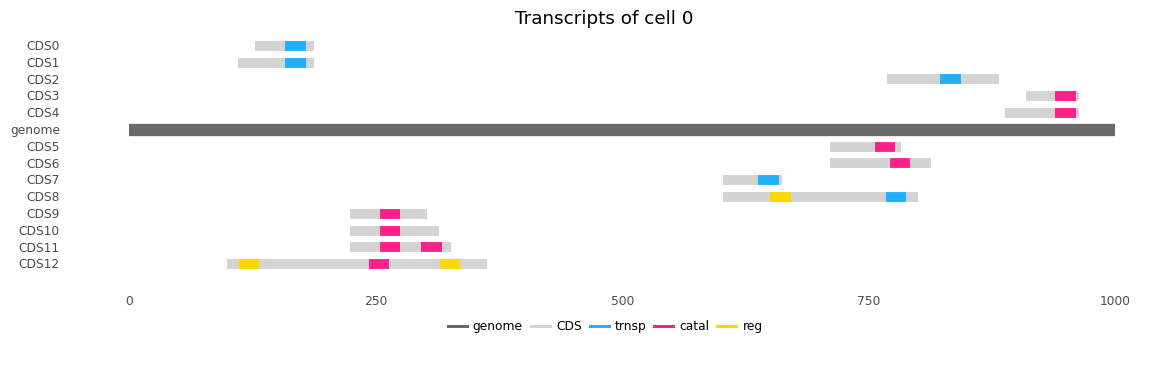

<ggplot: (8752199397049)>

In [7]:
cell_idx = 0
plot_genome_transcripts(cell_idx=cell_idx, world=world, title=f"Transcripts of cell {cell_idx}")

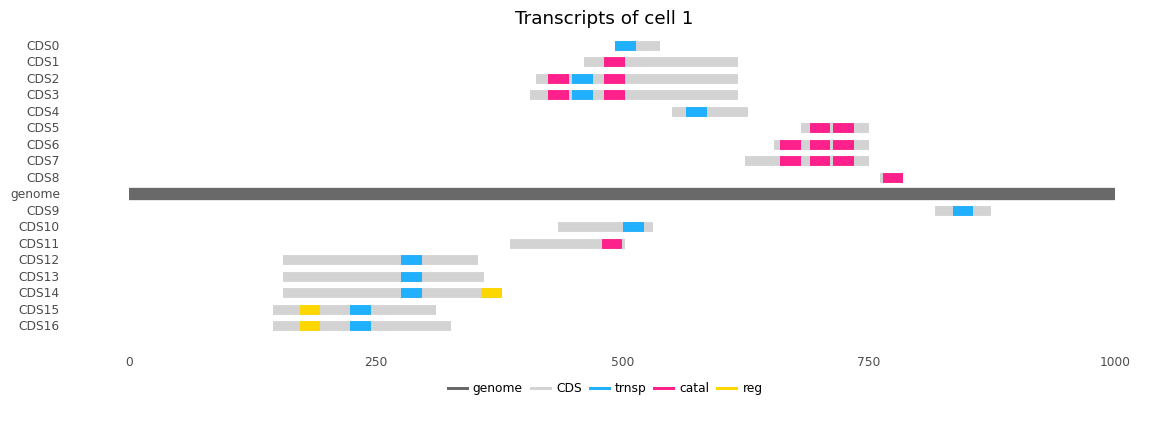

<ggplot: (8752198307750)>

In [8]:
cell_idx = 1
plot_genome_transcripts(cell_idx=cell_idx, world=world, title=f"Transcripts of cell {cell_idx}")

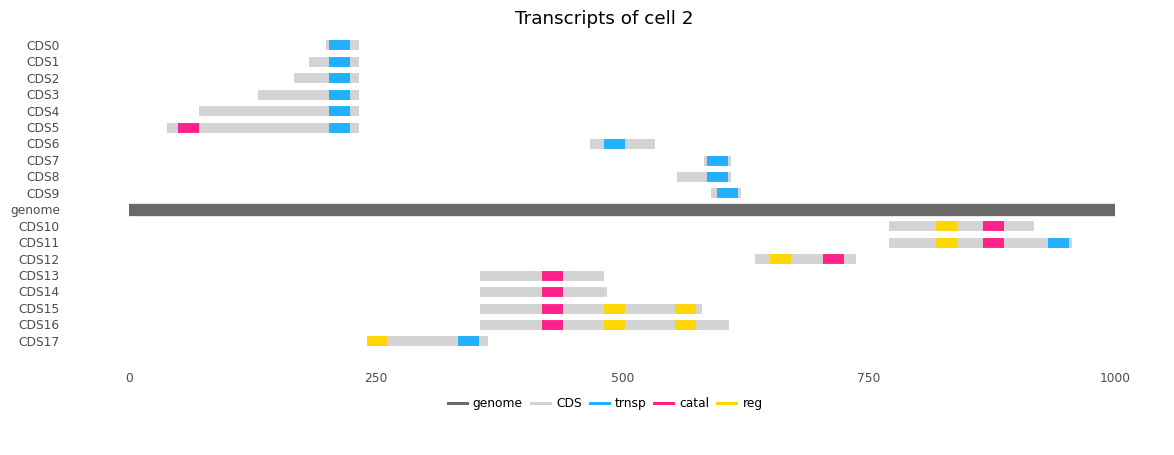

<ggplot: (8752198226674)>

In [9]:
cell_idx = 2
plot_genome_transcripts(cell_idx=cell_idx, world=world, title=f"Transcripts of cell {cell_idx}")

## Mutations

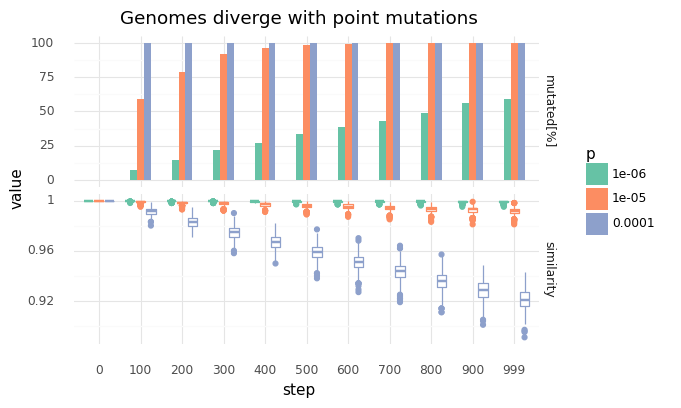

<ggplot: (8752199518548)>

In [10]:
n_steps = 1000
genome_size = 1000
map_size = 32
confluency = 0.5
probs = [1e-6, 1e-5, 1e-4]

def record_sequence_similarities(seqs0: list[str], seqs1: list[str], record: dict, records: list):
    for i, (s0, s1) in enumerate((zip(seqs0, seqs1))):
        minlen, maxlen = sorted([len(s0), len(s1)])
        d = 1.0 - distance(s0, s1) / maxlen if minlen > 0 else 0.0
        records.append({**record, "value": d, "i": i})

records = []
for prob in probs:
    n_cells = int(map_size ** 2 * confluency)
    world = ms.World(map_size=map_size, chemistry=ms.Chemistry(molecules=MOLECULES, reactions=REACTIONS))
    world.spawn_cells(genomes=[ms.random_genome(s=genome_size) for _ in range(n_cells)])
    original_genomes = [d for d in world.cell_genomes]
    genomes = [d for d in original_genomes]
    for step in range(n_steps):
        record = {"step": step, "p": prob}
        if step % 100 == 0:
            record_sequence_similarities(seqs0=genomes, seqs1=original_genomes, record=record, records=records)
        for seq, idx in ms.point_mutations(seqs=genomes, p=prob):
            genomes[idx] = seq
    record_sequence_similarities(seqs0=genomes, seqs1=original_genomes, record=record, records=records)

df = pd.DataFrame.from_records(records)
df["p"] = pd.Categorical(df["p"], categories=probs)
df["step"] = pd.Categorical(df["step"], categories=df["step"].unique())
df["measure"] = "similarity"
aggr = df.groupby(["p", "step"]) \
    .apply(lambda d: (d["value"] < 1.0).sum() / len(d) * 100) \
    .reset_index(name="value")
aggr["measure"] = "mutated[%]"
df = pd.concat([df, aggr], ignore_index=True)

(ggplot(df)
    + geom_boxplot(aes(x="step", y="value", color="p"), data=df[df["measure"] == "similarity"])
    + geom_col(aes(x="step", y="value", fill="p"), width=0.5, position="dodge", data=df[df["measure"] == "mutated[%]"])
    + facet_grid("measure ~ .", scales="free")
    + scale_fill_brewer(type="Qualitative", palette="Set2")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(6, 4))
    + ggtitle("Genomes diverge with point mutations"))

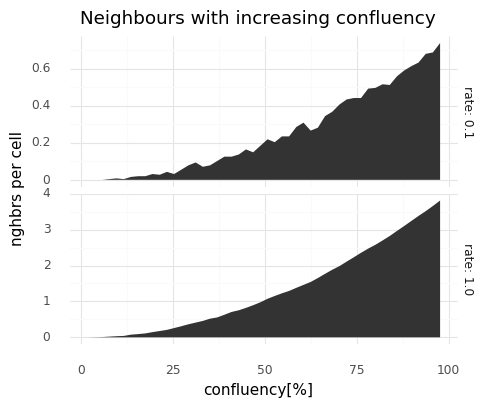

<ggplot: (8752199454717)>

In [11]:
n_steps = 50
map_size = 16
rates = [1.0, 0.1]

records = []
n = int(map_size ** 2 / n_steps)
world = ms.World(map_size=map_size, chemistry=ms.Chemistry(molecules=MOLECULES, reactions=REACTIONS))
for i in range(n_steps):
    world.spawn_cells(genomes=[ms.random_genome(s=100) for _ in range(n)])
    for rate in rates:
        idxs = torch.randperm(world.n_cells)[:int(world.n_cells * rate)]
        nghbrs = world.get_neighbors(cell_idxs=idxs.tolist())
        records.append({"cells": world.n_cells, "nghbrs": len(nghbrs), "rate": rate})
df = pd.DataFrame.from_records(records)
df["confluency[%]"] = df["cells"] / world.map_size ** 2 * 100
df["nghbrs per cell"] = df["nghbrs"] / world.map_size ** 2

(ggplot(df)
    + geom_area(aes(x="confluency[%]", y="nghbrs per cell"))
    + facet_grid("rate ~ .", labeller="label_both", scales="free")
    + theme(figure_size=(5, 4))
    + ggtitle("Neighbours with increasing confluency"))

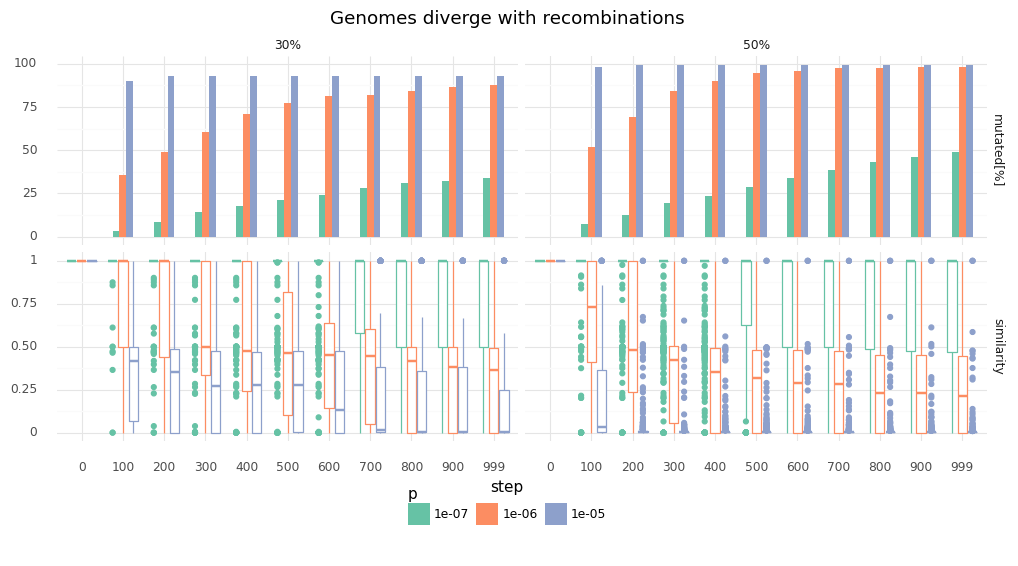

<ggplot: (8752199448778)>

In [14]:
n_steps = 1000
genome_size = 1000
map_size = 32
confluencies = [30, 50]
probs = [1e-8, 1e-7, 1e-6]

records = []
for con in confluencies:
    for prob in probs:
        n_cells = int(map_size ** 2 * con / 100)
        world = ms.World(map_size=map_size, chemistry=ms.Chemistry(molecules=MOLECULES, reactions=REACTIONS))
        world.spawn_cells(genomes=[ms.random_genome(s=genome_size) for _ in range(n_cells)])
        nghbrs = world.get_neighbors(cell_idxs=list(range(world.n_cells)))
        original_genomes = [d for d in world.cell_genomes]
        genomes = [d for d in original_genomes]
        for step in range(n_steps):
            record = {"step": step, "p": prob, "confluency[%]": f"{con:.0f}%"}
            if step % 100 == 0:
                record_sequence_similarities(seqs0=genomes, seqs1=original_genomes, record=record, records=records)
            genome_pairs = [(genomes[a], genomes[b]) for a, b in nghbrs]
            for sa, sb, idx in ms.recombinations(seq_pairs=genome_pairs, p=prob):
                a, b = nghbrs[idx]
                genomes[a] = sa
                genomes[b] = sb
        record_sequence_similarities(seqs0=genomes, seqs1=original_genomes, record=record, records=records)

df = pd.DataFrame.from_records(records)
df["p"] = pd.Categorical(df["p"], categories=probs)
df["step"] = pd.Categorical(df["step"], categories=df["step"].unique())
df["measure"] = "similarity"
aggr = df.groupby(["p", "confluency[%]", "step"]) \
    .apply(lambda d: (d["value"] < 1.0).sum() / len(d) * 100) \
    .reset_index(name="value")
aggr["measure"] = "mutated[%]"
df = pd.concat([df, aggr], ignore_index=True)

(ggplot(df)
    + geom_boxplot(aes(x="step", y="value", color="p"), data=df[df["measure"] == "similarity"])
    + geom_col(aes(x="step", y="value", fill="p"), width=0.5, position="dodge", data=df[df["measure"] == "mutated[%]"])
    + facet_grid("measure ~ confluency[%]", scales="free")
    + scale_fill_brewer(type="Qualitative", palette="Set2")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(12, 5))
    + theme(axis_title_y=element_blank())
    + theme(legend_position="bottom", legend_margin=10.0)
    + ggtitle("Genomes diverge with recombinations"))

## Molecule Diffusion and Degradation

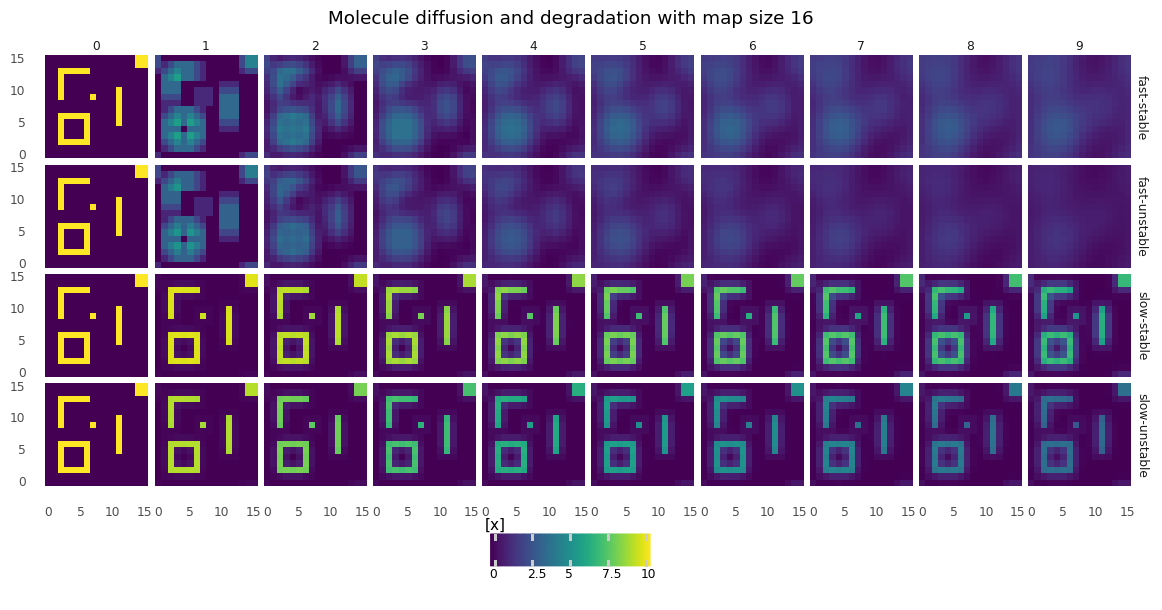

<ggplot: (8752204082264)>

In [15]:
ms.Molecule._instances = {}  # rm previous instances
molecules = [
    ms.Molecule("fast-stable", 10, diffusivity=1.0, half_life=1_000),
    ms.Molecule("fast-unstable", 10, diffusivity=1.0, half_life=10),
    ms.Molecule("slow-stable", 10, diffusivity=0.01, half_life=1_000),
    ms.Molecule("slow-unstable", 10, diffusivity=0.01, half_life=10)
]

chemistry = ms.Chemistry(molecules=molecules, reactions=[])
world = ms.World(chemistry=chemistry, map_size=16, mol_map_init="zeros")
world.molecule_map[:, 2:7, 2:7] = 10.0
world.molecule_map[:, 3:6, 3:6] = 0.0
world.molecule_map[:, 14:, 14:] = 10.0
world.molecule_map[:, 2:7, 13] = 10.0
world.molecule_map[:, 2, 9:13] = 10.0
world.molecule_map[:, 7, 9] = 10.0
world.molecule_map[:, 11, 5:11] = 10.0

records = []
for si in range(10):
    for mi, mol in enumerate(molecules):
        record = {"step": si, "mol": mol.name}
        for x, y in product(range(world.map_size), range(world.map_size)):
            records.append({
                **record,
                "x": x,
                "y": y,
                "[x]": world.molecule_map[mi, x, y].item()
            })
    world.diffuse_molecules()
    world.degrade_molecules()
df = pd.DataFrame.from_records(records)
df["mol"] = pd.Categorical(df["mol"], categories=[d.name for d in molecules], ordered=True)

(ggplot(df)
    + geom_raster(aes(x="x", y="y", fill="[x]"))
    + facet_grid("mol ~ step")
    + coord_equal(expand=False)
    + theme(figure_size=(14, 6))
    + theme(axis_title_x=element_blank(), axis_title_y=element_blank())
    + theme(legend_position="bottom", legend_margin=10.0)
    + ggtitle(f"Molecule diffusion and degradation with map size {world.map_size}"))

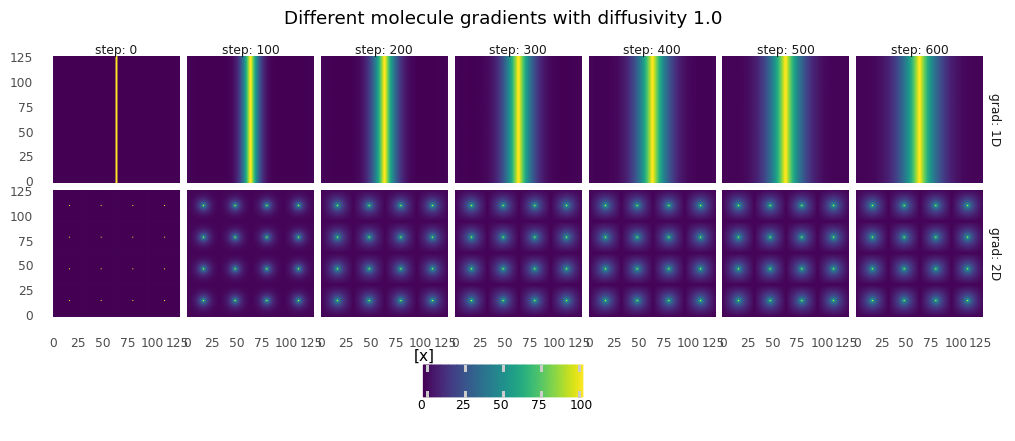

<ggplot: (8752153760027)>

In [16]:
mol_i = 0
dffy = chemistry.molecules[mol_i].diffusivity

def gradient1d(world: ms.World):
    world.molecule_map[mol_i, [63, 64]] = 100.0
    world.molecule_map[mol_i, [0, -1]] = 1.0

def gradient2d(world: ms.World):
    step = int(world.map_size / 4)
    half = int(step / 2)
    steps = [i * step for i in range(4)]
    for x in steps:
        for y in steps:
            world.molecule_map[mol_i, x + half, y + half] = 100.0
            world.molecule_map[mol_i, x, :] = 1.0
            world.molecule_map[mol_i, :, y] = 1.0

gradient_map = {
    "1D": gradient1d,
    "2D": gradient2d,
}

records = []
for label, fun in gradient_map.items():
    world = ms.World(chemistry=chemistry, mol_map_init="zeros")
    for si in range(601):
        fun(world=world)
        if si % 100 == 0:
            record = {"step": si, "grad": label}
            for x, y in product(range(128), range(128)):
                records.append({
                    **record,
                    "x": x,
                    "y": y,
                    "[x]": world.molecule_map[mol_i, x, y].item()
                })
        world.diffuse_molecules()
        world.degrade_molecules()

df = pd.DataFrame.from_records(records)

(ggplot(df)
    + geom_raster(aes(x="x", y="y", fill="[x]"))
    + facet_grid("grad ~ step", labeller="label_both")
    + coord_equal(expand=False)
    + theme(figure_size=(12, 6))
    + theme(axis_title_x=element_blank(), axis_title_y=element_blank())
    + theme(legend_position="bottom", legend_margin=10.0)
    + ggtitle(f"Different molecule gradients with diffusivity {dffy}"))

## Equilibrium Constants

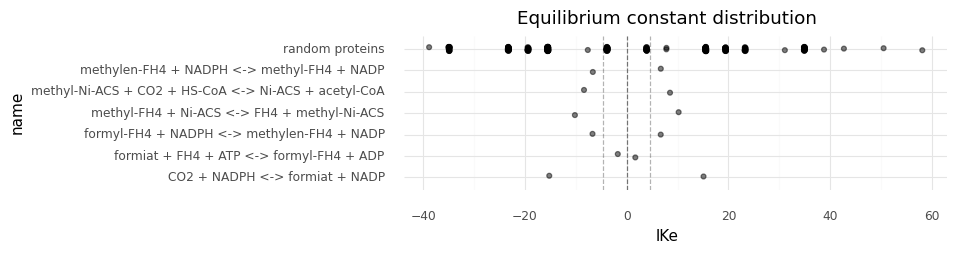

<ggplot: (8774883537464)>

In [17]:
world = ms.World(chemistry=CHEMISTRY)

records = []
for subs, prods in REACTIONS:
    name = " + ".join(str(d) for d in subs) + " <-> " + " + ".join(str(d) for d in prods)
    energy = sum(d.energy for d in prods) - sum(d.energy for d in subs)
    lke = -energy / GAS_CONSTANT / world.abs_temp / 2.303
    records.append({"name": name, "lKe": lke})
    records.append({"name": name, "lKe": -lke})

genomes = [ms.random_genome(s=500) for _ in range(100)]
world.spawn_cells(genomes=genomes)
lKe = torch.log(world.kinetics.Kmb / world.kinetics.Kmf)
for lke in lKe[lKe != 0.0].flatten().tolist():
    records.append({"name": "random proteins", "lKe": lke})

df = pd.DataFrame.from_records(records)

(ggplot(df, aes(x="name", y="lKe"))
    + geom_hline(yintercept=0.0, linetype="dashed", alpha=.5)
    + geom_hline(yintercept=[-4.6, 4.6], linetype="dashed", alpha=.3)
    + geom_jitter(data=df, alpha=.5, width=.1, height=.1)
    + coord_flip()
    + theme(figure_size=(7, 2))
    + ggtitle("Equilibrium constant distribution"))

/home/marc/anaconda3/envs/magicsoup_dev/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_ydensity : Removed 1030 rows containing non-finite values.


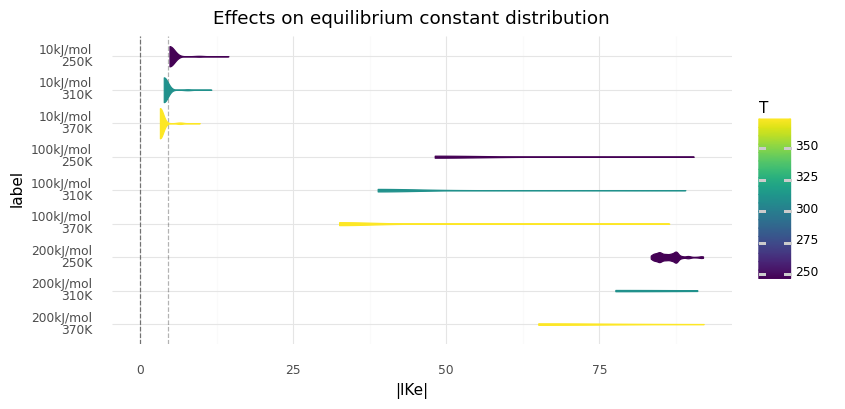

<ggplot: (8774884488688)>

In [26]:
abs_temps = [250, 310, 370]
energies = [10, 100, 200]
n_mols = 10

records = []
for energy in energies:
    for abs_temp in abs_temps:
        ms.Molecule._instances = {}  # rm previous instances
        molecules = [ms.Molecule(str(i), energy * 1e3) for i in range(n_mols)]
        reactions = [([a, b], [c]) for a, b, c in combinations(molecules, 3)]
        chemistry = ms.Chemistry(molecules=molecules, reactions=reactions)
        world = ms.World(chemistry=chemistry, abs_temp=abs_temp)
        genomes = [ms.random_genome(s=500) for _ in range(1000)]
        world.spawn_cells(genomes=genomes)
        lKe = torch.log(world.kinetics.Kmb / world.kinetics.Kmf).abs()
        label = f"{energy}kJ/mol\n{abs_temp}K"
        for lke in lKe[lKe != 0.0].flatten().tolist():
            records.append({"label": label, "|lKe|": lke, "T": abs_temp})

df = pd.DataFrame.from_records(records)
df["label"] = pd.Categorical(df["label"], categories=reversed(df["label"].unique()))

(ggplot(df)
    + geom_hline(yintercept=0, linetype="dashed", alpha=.5)
    + geom_hline(yintercept=4.6, linetype="dashed", alpha=.3)
    + geom_violin(aes(x="label", y="|lKe|", color="T", fill="T"), position="dodge")
    + coord_flip()
    + theme(figure_size=(8, 4))
    + ggtitle("Effects on equilibrium constant distribution"))

## Simple Reaction Kinetics

In [17]:
ms.Molecule._instances = {}  # rm previous instances
_ma = ms.Molecule("A", 10 * 1e3)
_mb = ms.Molecule("B", 5 * 1e3)
_mc = ms.Molecule("C", 20 * 1e3)
molecules = [_ma, _mb, _mc]
reactions = [([_ma, _mb], [_mc]), ([_ma, _ma, _ma], [_mc])]
chemistry = ms.Chemistry(molecules=molecules, reactions=reactions)
world = ms.World(chemistry=chemistry, map_size=8)

def generate_cell(proteome: list[ms.ProteinFact], size: int, world: ms.World, max_tries=3, allow_more_prots=False) -> int:
    n_prots = len(proteome)
    proteome_dom_counts = []
    for prot in proteome:
        proteome_dom_counts.append({
            ms.CatalyticDomain: sum(isinstance(d, ms.CatalyticDomainFact) for d in prot.domain_facts),
            ms.TransporterDomain: sum(isinstance(d, ms.TransporterDomainFact) for d in prot.domain_facts),
            ms.RegulatoryDomain: sum(isinstance(d, ms.RegulatoryDomainFact) for d in prot.domain_facts),
        })
    
    i = 0
    success = False
    idxs = []
    while not success:
        world.kill_cells(cell_idxs=idxs)
        i += 1
        if i > max_tries:
            raise ValueError(f"Could not generate cell after {i} tries")
        g = world.generate_genome(proteome=proteome, size=size)
        idxs = world.spawn_cells(genomes=[g])
        if len(idxs) != 1:
            continue
        cell = world.get_cell(by_idx=idxs[0])
        prots = cell.get_proteome(world=world)
        if not allow_more_prots and len(prots) != n_prots:
            continue
        found_prots = [False] * n_prots
        for i, dom_counts in enumerate(proteome_dom_counts):
            for prot in prots:
                found_doms = {d: False for d in dom_counts}
                for domtype, target in dom_counts.items():
                    if sum(isinstance(d, domtype) for d in prot.domains) == target:
                        found_doms[domtype] = True
                if all(found_doms.values()):
                    found_prots[i] = True
        if all(found_prots):
            return idxs[0]

def record_concentrations(record: dict, records: list, world: ms.World, cells_df: pd.DataFrame):
    for _, row in cells_df.iterrows():
        for mol, mi in world.kinetics.mol_2_mi.items():
            records.append({
                **record,
                "cell": int(row["cell"]),
                "location": "int",
                "molecule": mol.name,
                "[x]": world.cell_molecules[int(row["cell"]), mi].item(),
            })
            records.append({
                **record,
                "cell": int(row["cell"]),
                "location": "ext",
                "molecule": mol.name,
                "[x]": world.molecule_map[mi, int(row["x"]), int(row["y"])].item()
            })

def run_enzymatic_activity(n_steps: int, world: ms.World, cells_df: pd.DataFrame) -> pd.DataFrame:
    records = []
    for si in range(n_steps):
        record_concentrations(record={"step": si}, records=records, world=world, cells_df=cells_df)
        world.enzymatic_activity()
    return pd.DataFrame.from_records(records)

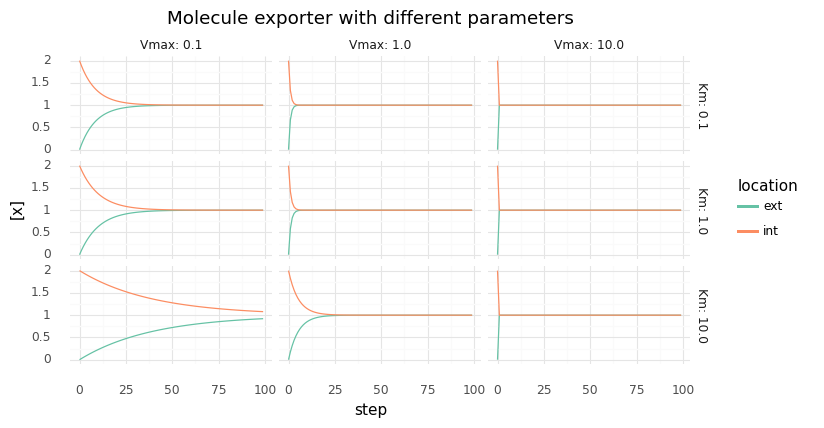

<ggplot: (8752147401668)>

In [18]:
n_steps = 100
kms = [0.1, 1.0, 10.0]
vmaxs = [0.1, 1.0, 10.0]

records = []
for km in kms:
    for vmax in vmaxs:
        p0 = ms.ProteinFact(domain_facts=ms.TransporterDomainFact(molecule=_ma, km=km, vmax=vmax, is_exporter=True))
        ci = generate_cell(proteome=[p0], size=27, world=world)
        cell = world.get_cell(by_idx=ci)
        records.append({
            "cell": ci,
            "Vmax": vmax,
            "Km": km,
            "x": cell.position[0],
            "y": cell.position[1]
        })

cells_df = pd.DataFrame.from_records(records)
cells_df["Km"] = pd.Categorical(cells_df["Km"], categories=kms)
cells_df["Vmax"] = pd.Categorical(cells_df["Vmax"], categories=vmaxs)

world.molecule_map[:] = 0.0
world.cell_molecules[:] = 2.0
sim_df = run_enzymatic_activity(world=world, n_steps=n_steps, cells_df=cells_df)
df = pd.merge(cells_df, sim_df[sim_df["molecule"] == "A"], on="cell")
world.kill_cells(cell_idxs=list(range(world.n_cells)))

(ggplot(df)
    + geom_line(aes(x="step", y="[x]", color="location"))
    + facet_grid("Km ~ Vmax", labeller="label_both", scales="fixed")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(8, 4))
    + ggtitle("Molecule exporter with different parameters"))

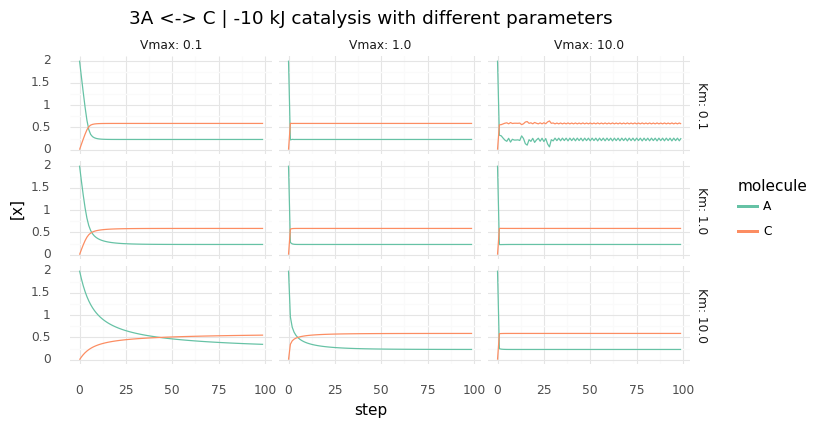

<ggplot: (8752204243026)>

In [19]:
n_steps = 100
kms = [0.1, 1.0, 10.0]
vmaxs = [0.1, 1.0, 10.0]
name = f"3A <-> C | {(_mc.energy - 3 * _ma.energy) / 1e3:,.0f} kJ catalysis"

records = []
for km in kms:
    for vmax in vmaxs:
        p0 = ms.ProteinFact(domain_facts=ms.CatalyticDomainFact(reaction=([_ma, _ma, _ma], [_mc]), km=km, vmax=vmax))
        ci = generate_cell(proteome=[p0], size=27, world=world)
        cell = world.get_cell(by_idx=ci)
        records.append({
            "cell": ci,
            "Vmax": vmax,
            "Km": km,
            "x": cell.position[0],
            "y": cell.position[1]
        })

cells_df = pd.DataFrame.from_records(records)
cells_df["Km"] = pd.Categorical(cells_df["Km"], categories=kms)
cells_df["Vmax"] = pd.Categorical(cells_df["Vmax"], categories=vmaxs)

world.cell_molecules[:] = 0.0
world.cell_molecules[:, 0] = 2.0
sim_df = run_enzymatic_activity(world=world, n_steps=n_steps, cells_df=cells_df)
df = pd.merge(cells_df, sim_df[sim_df["location"] == "int"], on="cell")
world.kill_cells(cell_idxs=list(range(world.n_cells)))

(ggplot(df[df["molecule"] != "B"])
    + geom_line(aes(x="step", y="[x]", color="molecule"))
    + facet_grid("Km ~ Vmax", labeller="label_both", scales="fixed")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(8, 4))
    + ggtitle(f"{name} with different parameters"))

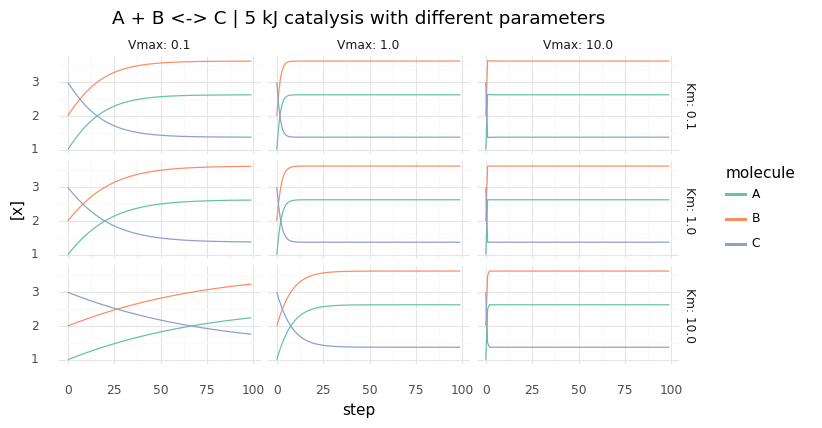

<ggplot: (8745556587139)>

In [19]:
n_steps = 100
kms = [0.1, 1.0, 10.0]
vmaxs = [0.1, 1.0, 10.0]
name = f"A + B <-> C | {(_mc.energy - _ma.energy - _mb.energy) / 1e3:,.0f} kJ catalysis"

records = []
for km in kms:
    for vmax in vmaxs:
        p0 = ms.ProteinFact(domain_facts=ms.CatalyticDomainFact(reaction=([_ma, _mb], [_mc]), km=km, vmax=vmax))
        ci = generate_cell(proteome=[p0], size=27, world=world)
        cell = world.get_cell(by_idx=ci)
        records.append({
            "cell": ci,
            "Vmax": vmax,
            "Km": km,
            "x": cell.position[0],
            "y": cell.position[1]
        })

cells_df = pd.DataFrame.from_records(records)
cells_df["Km"] = pd.Categorical(cells_df["Km"], categories=kms)
cells_df["Vmax"] = pd.Categorical(cells_df["Vmax"], categories=vmaxs)

world.cell_molecules[:, 0] = 1.0
world.cell_molecules[:, 1] = 2.0
world.cell_molecules[:, 2] = 3.0
sim_df = run_enzymatic_activity(world=world, n_steps=n_steps, cells_df=cells_df)
df = pd.merge(cells_df, sim_df[sim_df["location"] == "int"], on="cell")
world.kill_cells(cell_idxs=list(range(world.n_cells)))


(ggplot(df)
    + geom_line(aes(x="step", y="[x]", color="molecule"))
    + facet_grid("Km ~ Vmax", labeller="label_both", scales="fixed")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(8, 4))
    + ggtitle(f"{name} with different parameters"))

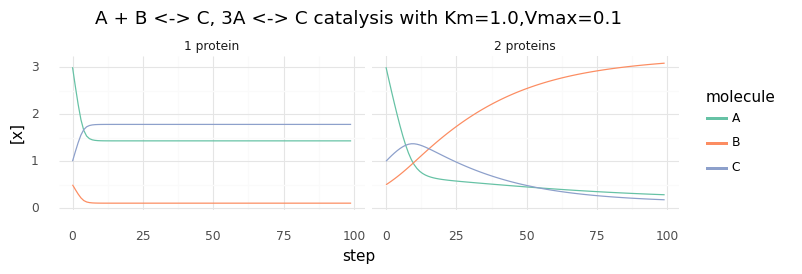

<ggplot: (8745556651516)>

In [23]:
n_steps = 100
km = 1.0
vmax = 0.1
name = f"A + B <-> C, 3A <-> C catalysis with Km={km:.1f},Vmax={vmax:.1f}"

records = []
world.kill_cells(cell_idxs=list(range(world.n_cells)))
p0 = ms.ProteinFact(domain_facts=ms.CatalyticDomainFact(reaction=([_ma, _mb], [_mc]), km=km, vmax=vmax))
p1 = ms.ProteinFact(domain_facts=ms.CatalyticDomainFact(reaction=([_ma, _ma, _ma], [_mc]), km=km, vmax=vmax))
ci = generate_cell(proteome=[p0, p1], size=54, world=world)
cell = world.get_cell(by_idx=ci)
records.append({
    "cell": ci,
    "type": "2 proteins",
    "x": cell.position[0],
    "y": cell.position[1]
})

p0 = ms.ProteinFact(domain_facts=[
    ms.CatalyticDomainFact(reaction=([_ma, _mb], [_mc]), km=km, vmax=vmax),
    ms.CatalyticDomainFact(reaction=([_ma, _ma, _ma], [_mc]), km=km, vmax=vmax)
])
ci = generate_cell(proteome=[p0], size=48, world=world, max_tries=10)
cell = world.get_cell(by_idx=ci)
records.append({
    "cell": ci,
    "type": "1 protein",
    "x": cell.position[0],
    "y": cell.position[1]
})

cells_df = pd.DataFrame.from_records(records)

world.cell_molecules[:, 0] = 3.0
world.cell_molecules[:, 1] = 0.5
world.cell_molecules[:, 2] = 1.0
sim_df = run_enzymatic_activity(world=world, n_steps=n_steps, cells_df=cells_df)
df = pd.merge(cells_df, sim_df[sim_df["location"] == "int"], on="cell")
world.kill_cells(cell_idxs=list(range(world.n_cells)))

(ggplot(df)
    + geom_line(aes(x="step", y="[x]", color="molecule"))
    + facet_grid(". ~ type")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(8, 2))
    + ggtitle(name))

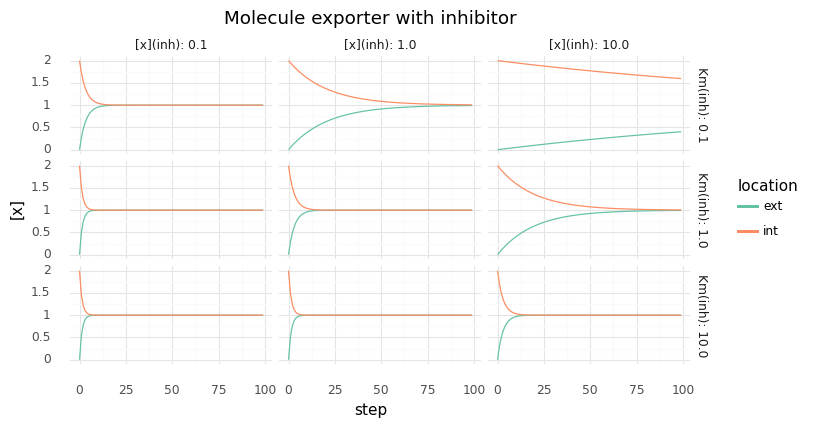

<ggplot: (8745737947638)>

In [26]:
n_steps = 100
kms = [0.1, 1.0, 10.0]
concentrations = [0.1, 1.0, 10.0]

records = []
world.kill_cells(cell_idxs=list(range(world.n_cells)))
for km in kms:
    for x in concentrations:
        p0 = ms.ProteinFact(domain_facts=[
            ms.TransporterDomainFact(molecule=_ma, km=1.0, vmax=1.0, is_exporter=True),
            ms.RegulatoryDomainFact(effector=_mb, km=km, is_inhibiting=True, is_transmembrane=False, hill=1)
        ])
        ci = generate_cell(proteome=[p0], size=48, world=world, max_tries=10)
        cell = world.get_cell(by_idx=ci)
        records.append({
            "cell": ci,
            "Km(inh)": km,
            "[x](inh)": x,
            "x": cell.position[0],
            "y": cell.position[1]
        })

cells_df = pd.DataFrame.from_records(records)
cells_df["Km(inh)"] = pd.Categorical(cells_df["Km(inh)"], categories=kms)
cells_df["[x](inh)"] = pd.Categorical(cells_df["[x](inh)"], categories=concentrations)

world.molecule_map[:] = 0.0
world.cell_molecules[:, 0] = 2.0
for x in concentrations:
    is_x = cells_df.loc[cells_df["[x](inh)"] == x, "cell"].tolist()
    world.cell_molecules[is_x, 1] = x

sim_df = run_enzymatic_activity(world=world, n_steps=n_steps, cells_df=cells_df)
df = pd.merge(cells_df, sim_df[sim_df["molecule"] == "A"], on="cell")
world.kill_cells(cell_idxs=list(range(world.n_cells)))

(ggplot(df)
    + geom_line(aes(x="step", y="[x]", color="location"))
    + facet_grid("Km(inh) ~ [x](inh)", labeller="label_both", scales="fixed")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(8, 4))
    + ggtitle("Molecule exporter with inhibitor"))

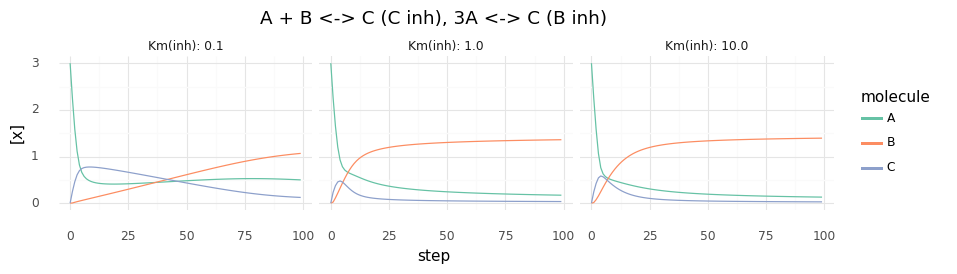

<ggplot: (8745749142312)>

In [31]:
name = "A + B <-> C (C inh), 3A <-> C (B inh)"
n_steps = 100
kms = [0.1, 1.0, 10.0]

records = []
world.kill_cells(cell_idxs=list(range(world.n_cells)))
for km in kms:
    p0 = ms.ProteinFact(domain_facts=[
        ms.CatalyticDomainFact(reaction=([_ma, _mb], [_mc]), km=1.0, vmax=0.3),
        ms.RegulatoryDomainFact(effector=_mc, km=km, is_inhibiting=True, is_transmembrane=False, hill=1)
    ])
    p1 = ms.ProteinFact(domain_facts=[
        ms.CatalyticDomainFact(reaction=([_ma, _ma, _ma], [_mc]), km=1.0, vmax=0.3),
        ms.RegulatoryDomainFact(effector=_mb, km=km, is_inhibiting=True, is_transmembrane=False, hill=1)
    ])
    ci = generate_cell(proteome=[p0, p1], size=96, world=world, max_tries=20, allow_more_prots=True)
    cell = world.get_cell(by_idx=ci)
    records.append({
        "cell": ci,
        "Km(inh)": km,
        "x": cell.position[0],
        "y": cell.position[1]
    })

cells_df = pd.DataFrame.from_records(records)
cells_df["Km(inh)"] = pd.Categorical(cells_df["Km(inh)"], categories=kms)

world.cell_molecules[:] = 0.0
world.cell_molecules[:, 0] = 3.0
sim_df = run_enzymatic_activity(world=world, n_steps=n_steps, cells_df=cells_df)
df = pd.merge(cells_df, sim_df[sim_df["location"] == "int"], on="cell")
world.kill_cells(cell_idxs=list(range(world.n_cells)))

(ggplot(df)
    + geom_line(aes(x="step", y="[x]", color="molecule"))
    + facet_grid(". ~ Km(inh)", labeller="label_both", scales="fixed")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(10, 2))
    + ggtitle(name))

## Biochemical Patterns

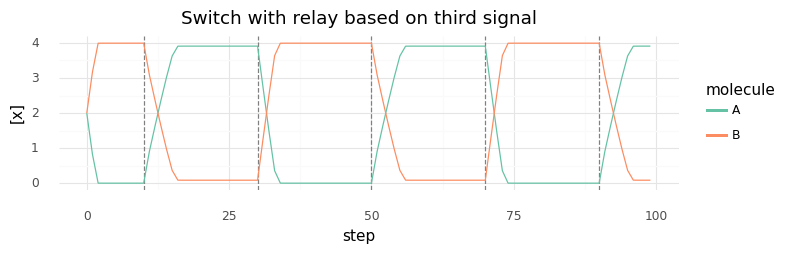

<ggplot: (8745737881973)>

In [32]:
n_steps = 100
every_n = 20
reg_km = 1.0
low_high = (0.0, 4.0)
switches = [10, 30, 50, 70, 90]

ms.Molecule._instances = {}  # rm previous instances
_ma = ms.Molecule("A", 10 * 1e3)
_mb = ms.Molecule("B", 10 * 1e3)
_mc = ms.Molecule("C", 10 * 1e3)
_me = ms.Molecule("E", 10 * 1e3)
molecules = [_ma, _mb, _mc, _me]
reactions = [([_ma, _me], [_mb]), ([_mb, _me], [_ma])]
chemistry = ms.Chemistry(molecules=molecules, reactions=reactions)
world = ms.World(chemistry=chemistry, map_size=2)

p0 = ms.ProteinFact(domain_facts=[
    ms.CatalyticDomainFact(reaction=([_ma, _me], [_mb]), km=1.0, vmax=1.0),
    ms.RegulatoryDomainFact(effector=_mc, is_transmembrane=False, is_inhibiting=True, km=reg_km, hill=1)
])
p1 = ms.ProteinFact(domain_facts=[
    ms.CatalyticDomainFact(reaction=([_mb, _me], [_ma]), km=1.0, vmax=1.0),
    ms.RegulatoryDomainFact(effector=_mc, is_transmembrane=False, is_inhibiting=False, km=reg_km, hill=1)
])

ci = generate_cell(proteome=[p0, p1], size=96, world=world, max_tries=10)
cell = world.get_cell(by_idx=ci)
records = [{"cell": ci, "x": cell.position[0], "y": cell.position[1]}]
cells_df = pd.DataFrame.from_records(records)

world.cell_molecules[:] = 2.0
is_high = False
records = []
for step in range(n_steps):
    if step in switches:
        is_high = not is_high
    world.cell_molecules[:, 2] = low_high[1 if is_high else 0]
    world.cell_molecules[:, 3] = 10.0
    record_concentrations(record={"step": step}, records=records, world=world, cells_df=cells_df)
    world.enzymatic_activity()

sim_df = pd.DataFrame.from_records(records)
df = pd.merge(cells_df, sim_df[sim_df["location"] == "int"], on="cell")

(ggplot(df[df["molecule"].isin(["A", "B"])])
    + geom_vline(aes(xintercept="x"), linetype="dashed", color="gray", data=pd.DataFrame({"x": switches}))
    + geom_line(aes(x="step", y="[x]", color="molecule"))
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(8, 2))
    + ggtitle("Switch with relay based on third signal"))

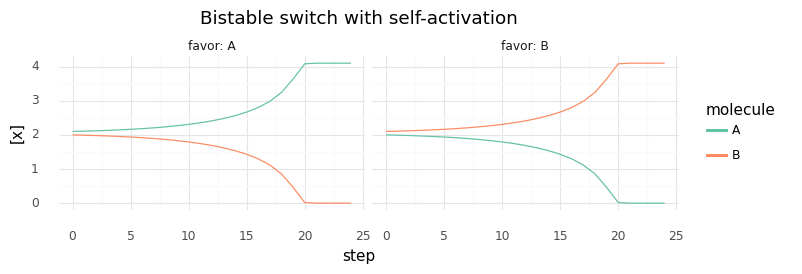

<ggplot: (8745733752863)>

In [35]:
n_steps = 25
reg_km = 1.0

ms.Molecule._instances = {}  # rm previous instances
_ma = ms.Molecule("A", 10 * 1e3)
_mb = ms.Molecule("B", 10 * 1e3)
_me = ms.Molecule("E", 100 * 1e3)
molecules = [_ma, _mb, _me]
reactions = [([_ma, _me], [_mb]), ([_mb, _me], [_ma])]
chemistry = ms.Chemistry(molecules=molecules, reactions=reactions)
world = ms.World(chemistry=chemistry, map_size=2)

p0 = ms.ProteinFact(domain_facts=[
    ms.CatalyticDomainFact(reaction=([_ma, _me], [_mb]), km=1.0, vmax=1.0),
    ms.RegulatoryDomainFact(effector=_ma, is_transmembrane=False, is_inhibiting=True, km=reg_km, hill=3),
])
p1 = ms.ProteinFact(domain_facts=[
    ms.CatalyticDomainFact(reaction=([_mb, _me], [_ma]), km=1.0, vmax=1.0),
    ms.RegulatoryDomainFact(effector=_mb, is_transmembrane=False, is_inhibiting=True, km=reg_km, hill=3),
])

records = []
for mol in (_ma, _mb):
    ci = generate_cell(proteome=[p0, p1], size=96, world=world, max_tries=10)
    cell = world.get_cell(by_idx=ci)
    records.append({"cell": ci, "x": cell.position[0], "y": cell.position[1], "favor": mol.name})
    world.cell_molecules[ci, :] = 2.0
    world.cell_molecules[ci, world.kinetics.mol_2_mi[mol]] += 0.1
cells_df = pd.DataFrame.from_records(records)

records = []
for step in range(n_steps):
    world.cell_molecules[:, 2] = 10.0
    record_concentrations(record={"step": step}, records=records, world=world, cells_df=cells_df)
    world.enzymatic_activity()

sim_df = pd.DataFrame.from_records(records)
df = pd.merge(cells_df, sim_df[sim_df["location"] == "int"], on="cell")

(ggplot(df[df["molecule"].isin(["A", "B"])])
    + geom_line(aes(x="step", y="[x]", color="molecule"))
    + facet_grid(". ~ favor", labeller="label_both")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(8, 2))
    + ggtitle("Bistable switch with self-activation"))

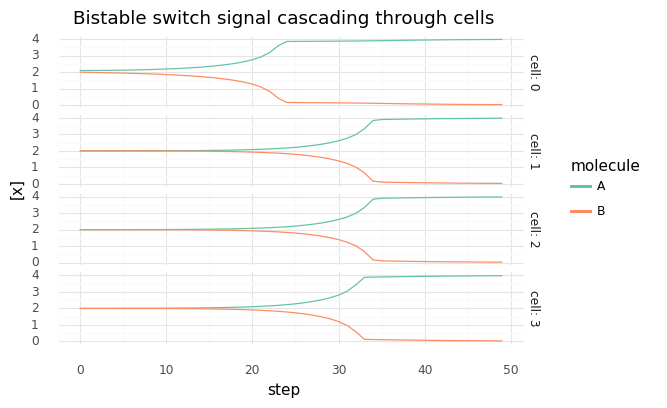

<ggplot: (8745749480382)>

In [36]:
n_steps = 50
reg_km = 1.0

ms.Molecule._instances = {}  # rm previous instances
_ma = ms.Molecule("A", 10 * 1e3, permeability=0.1)
_mb = ms.Molecule("B", 10 * 1e3, permeability=0.1)
_me = ms.Molecule("E", 100 * 1e3)
molecules = [_ma, _mb, _me]
reactions = [([_ma, _me], [_mb]), ([_mb, _me], [_ma])]
chemistry = ms.Chemistry(molecules=molecules, reactions=reactions)
world = ms.World(chemistry=chemistry, map_size=2, mol_map_init="zeros")

p0 = ms.ProteinFact(domain_facts=[
    ms.CatalyticDomainFact(reaction=([_ma, _me], [_mb]), km=1.0, vmax=1.0),
    ms.RegulatoryDomainFact(effector=_ma, is_transmembrane=False, is_inhibiting=True, km=reg_km, hill=3),
])
p1 = ms.ProteinFact(domain_facts=[
    ms.CatalyticDomainFact(reaction=([_mb, _me], [_ma]), km=1.0, vmax=1.0),
    ms.RegulatoryDomainFact(effector=_mb, is_transmembrane=False, is_inhibiting=True, km=reg_km, hill=3),
])

records = []
for _ in range(world.map_size**2):
    ci = generate_cell(proteome=[p0, p1], size=96, world=world, max_tries=10)
    cell = world.get_cell(by_idx=ci)
    records.append({"cell": ci, "x": cell.position[0], "y": cell.position[1]})
cells_df = pd.DataFrame.from_records(records)

world.molecule_map[:] = 2.0
world.cell_molecules[:] = 2.0
world.cell_molecules[0, 0] += 0.1
records = []
for step in range(n_steps):
    world.cell_molecules[:, 2] = 10.0
    record_concentrations(record={"step": step}, records=records, world=world, cells_df=cells_df)
    world.enzymatic_activity()
    world.diffuse_molecules()

sim_df = pd.DataFrame.from_records(records)
df = pd.merge(cells_df, sim_df[sim_df["location"] == "int"], on="cell")

(ggplot(df[df["molecule"].isin(["A", "B"])])
    + geom_line(aes(x="step", y="[x]", color="molecule"))
    + facet_grid("cell ~ .", labeller="label_both")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(6, 4))
    + ggtitle("Bistable switch signal cascading through cells"))

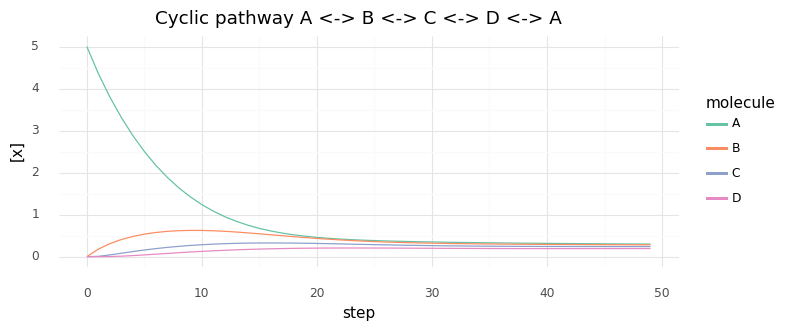

<ggplot: (8745738004835)>

In [51]:
km = 10.0
vmax = 0.3

ms.Molecule._instances = {}  # rm previous instances
_ma = ms.Molecule("A", 10 * 1e3, permeability=0.1)
_mb = ms.Molecule("B", 10 * 1e3, permeability=0.1)
_mc = ms.Molecule("C", 10 * 1e3, permeability=0.1)
_md = ms.Molecule("D", 10 * 1e3, permeability=0.1)
_me = ms.Molecule("E", 100 * 1e3)
molecules = [_ma, _mb, _mc, _md, _me]
reactions = [([_ma, _me], [_mb]), ([_mb, _me], [_mc]), ([_mc, _me], [_md]), ([_md, _me], [_ma])]
chemistry = ms.Chemistry(molecules=molecules, reactions=reactions)
world = ms.World(chemistry=chemistry, map_size=2, mol_map_init="zeros")

p0 = ms.ProteinFact(domain_facts=[ms.CatalyticDomainFact(reaction=([_ma, _me], [_mb]), km=km, vmax=vmax)])
p1 = ms.ProteinFact(domain_facts=[ms.CatalyticDomainFact(reaction=([_mb, _me], [_mc]), km=km, vmax=vmax)])
p2 = ms.ProteinFact(domain_facts=[ms.CatalyticDomainFact(reaction=([_mc, _me], [_md]), km=km, vmax=vmax)])
p3 = ms.ProteinFact(domain_facts=[ms.CatalyticDomainFact(reaction=([_md, _me], [_ma]), km=km, vmax=vmax)])

ci = generate_cell(proteome=[p0, p1, p2, p3], size=108, world=world, max_tries=10)
cell = world.get_cell(by_idx=ci)
record = {"cell": ci, "x": cell.position[0], "y": cell.position[1]}
cells_df = pd.DataFrame.from_records([record])

world.cell_molecules[0, 0] = 5.0
records = []
for step in range(n_steps):
    world.cell_molecules[:, 4] = 10.0
    record_concentrations(record={"step": step}, records=records, world=world, cells_df=cells_df)
    world.enzymatic_activity()
    world.diffuse_molecules()

sim_df = pd.DataFrame.from_records(records)
df = pd.merge(cells_df, sim_df[sim_df["location"] == "int"], on="cell")

(ggplot(df[df["molecule"] != "E"])
    + geom_line(aes(x="step", y="[x]", color="molecule"))
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(8, 3))
    + ggtitle("Cyclic pathway A <-> B <-> C <-> D <-> A"))

## Free Energy in Simulation

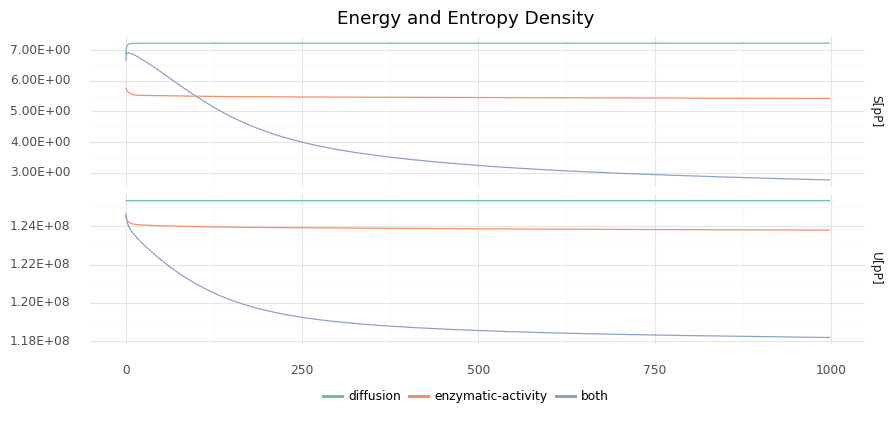

<ggplot: (8772934918138)>

In [14]:
n_steps = 1000
map_size = 8
confluency = 0.5
genome_size = 1000

world = ms.World(map_size=map_size, chemistry=CHEMISTRY)
molmap = torch.rand_like(world.molecule_map) * 100
max_ = molmap.max().item()
n_cells = int(map_size ** 2 * confluency)
genomes = [ms.random_genome(s=genome_size) for _ in range(n_cells)]

def init_world() -> ms.World:
    world.kill_cells(cell_idxs=range(world.n_cells))
    world.molecule_map = molmap.clone()
    world.spawn_cells(genomes=genomes)
    return world

def world_energy(world: ms.World) -> float:
    energies = torch.tensor([d.energy for d in world.chemistry.molecules])
    e_map = torch.einsum("mxy,m->xy", world.molecule_map, energies)
    e_cells = torch.einsum("cm,m->c", world.cell_molecules, energies)
    return (e_map.sum() + e_cells.sum()).item()

def world_entropy(world: ms.World) -> float:
    t = torch.cat([world.molecule_map.flatten(), world.cell_molecules.flatten()]) / max_
    return (-t * torch.log(t + 1e-10)).sum().item()

def record_energy_entropy(record: dict, records: list, world: ms.World):
      records.append({**record, "value": world_energy(world), "variable": "U"})
      records.append({**record, "value": world_entropy(world), "variable": "S"})

records = []

world = init_world()
for step_i in range(n_steps):
    world.diffuse_molecules()
    record_energy_entropy(record={"label": "diffusion", "step": step_i}, records=records, world=world)

world = init_world()
for step_i in range(n_steps):
    world.enzymatic_activity()
    record_energy_entropy(record={"label": "enzymatic-activity", "step": step_i}, records=records, world=world)

world = init_world()
for step_i in range(n_steps):
    world.enzymatic_activity()
    world.diffuse_molecules()
    record_energy_entropy(record={"label": "both", "step": step_i}, records=records, world=world)

df = pd.DataFrame.from_records(records)
df["label"] = pd.Categorical(df["label"], categories=["diffusion", "enzymatic-activity", "both"])
df["value"] = df["value"] / map_size ** 2
df["variable"] = df["variable"] + "[pP]"

(ggplot(df)
    + geom_line(aes(x="step", y="value", color="label"))
    + scale_y_continuous(labels=lambda d: [f"{dd:.2E}" for dd in d])
    + facet_grid("variable ~ .", scales="free")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(10, 4))
    + theme(legend_position="bottom", legend_title=element_blank(), axis_title=element_blank(), legend_margin=10)
    + ggtitle("Energy and Entropy Density"))

## Survival and Replication Rate

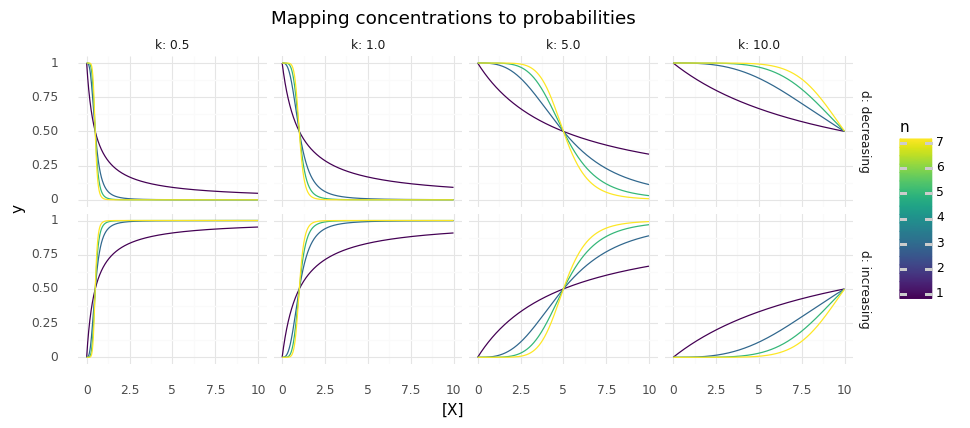

<ggplot: (8740123437053)>

In [30]:
def increasing(t: torch.Tensor, k: float, n: int) -> torch.Tensor:
    return t ** n / (t ** n + k ** n)

def decreasing(t: torch.Tensor, k: float, n: int) -> torch.Tensor:
    return k ** n / (t ** n + k ** n)

X = torch.arange(0, 10, .01)

dfs = []
for k in (0.5, 1, 5, 10):
    for n in (1, 3, 5, 7):
        df = pd.DataFrame({
            "[X]": X.tolist() + X.tolist(),
            "y": increasing(X, k, n).tolist() + decreasing(X, k, n).tolist(),
            "d": ["increasing"] * len(X) + ["decreasing"] * len(X),
            "k": 2 * [k] * len(X),
            "n": 2 * [n] * len(X)
        })
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

(ggplot(df, aes(y="y", x="[X]"))
    + geom_line(aes(color="n", group="n"))
    + facet_grid("d ~ k", scales="free", labeller="label_both")
    + theme(figure_size=(10, 4))
    + ggtitle("Mapping concentrations to probabilities"))

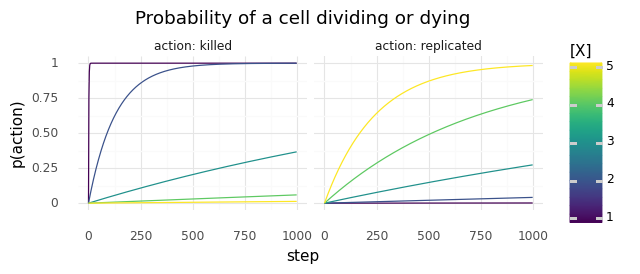

<ggplot: (8740131052541)>

In [32]:
def replicate(t: torch.Tensor, k=15, n=5) -> torch.Tensor:
    return t ** n / (t ** n + k ** n)

def kill(t: torch.Tensor, k=1, n=7) -> torch.Tensor:
    return k ** n / (t ** n + k ** n)

actions = {"replicated": replicate, "killed": kill}
n_mols = [1.0, 2.0, 3.0, 4.0, 5.0]
n_steps = 1000

records = []
for n_mol in n_mols:
    for action, fun in actions.items():
        for step in range(n_steps):
            records.append({
                "step": step,
                "[X]": n_mol,
                "p(action)": (1 - (1 - fun(n_mol)) ** step),
                "action": action,
            })

df = pd.DataFrame.from_records(records)

(ggplot(df, aes(y="p(action)", x="step"))
    + geom_line(aes(color="[X]", group="[X]"))
    + facet_grid(". ~ action", labeller="label_both")
    + theme(figure_size=(6, 2))
    + ggtitle("Probability of a cell dividing or dying"))

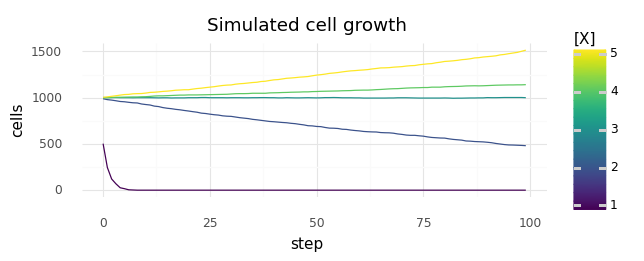

<ggplot: (8740131059899)>

In [34]:
def sample(p: torch.Tensor) -> list[int]:
    idxs = torch.argwhere(torch.bernoulli(p))
    return idxs.flatten().tolist()

n_cells = 1000
n_steps = 100
n_mols = [1, 2, 3, 4, 5]

records = []
for n_mol in n_mols:
    X = torch.ones(n_cells) * n_mol
    for step in range(n_steps):
        
        kidxs = sample(kill(X))
        keep = torch.ones(X.size(), dtype=bool)
        keep[kidxs] = False
        X = X[keep]

        ridxs = sample(replicate(X))
        X = torch.cat([X, torch.ones(len(ridxs)) * n_mol])
        
        records.append({
            "step": step,
            "[X]": n_mol,
            "cells": len(X),
        })

        if len(X) > 1e6:
            break

df = pd.DataFrame.from_records(records)

(ggplot(df, aes(y="cells", x="step"))
    + geom_line(aes(color="[X]", group="[X]"))
    + theme(figure_size=(6, 2))
    + ggtitle("Simulated cell growth"))

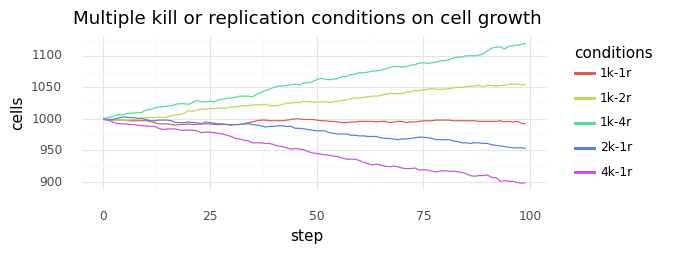

<ggplot: (8740131940719)>

In [36]:
n_cells = 1000
n_steps = 100
n_mol = 3.07 # to get 1k-1r in equilibrium
setups = [(1, 1), (1, 2), (1, 4), (2, 1), (4, 1)]

records = []
for n_kills, n_replications in setups:
    X = torch.ones(n_cells) * n_mol
    label = f"{n_kills}k-{n_replications}r"
    for step in range(n_steps):
        
        for _ in range(n_kills):
            kidxs = sample(kill(X))
            keep = torch.ones(X.size(), dtype=bool)
            keep[kidxs] = False
            X = X[keep]

        for _ in range(n_replications):
            ridxs = sample(replicate(X))
            X = torch.cat([X, torch.ones(len(ridxs)) * n_mol])
        
        records.append({
            "step": step,
            "cells": len(X),
            "conditions": label,
        })

        if len(X) > 1e6:
            break

df = pd.DataFrame.from_records(records)

(ggplot(df, aes(y="cells", x="step"))
    + geom_line(aes(color="conditions"))
    + theme(figure_size=(6, 2))
    + ggtitle("Multiple kill or replication conditions on cell growth"))

## Passaging

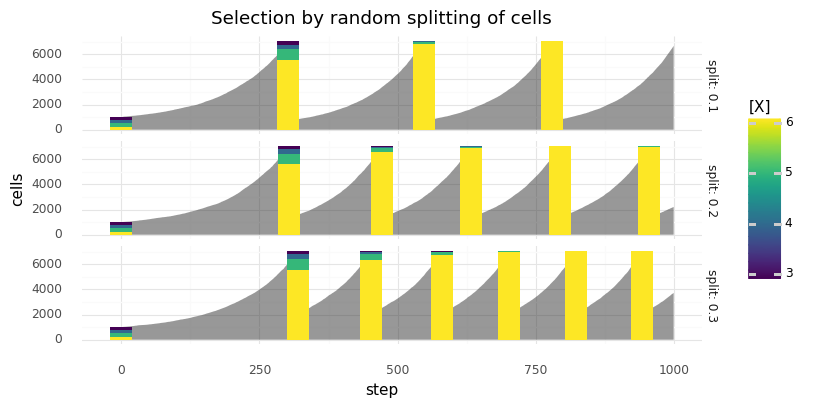

<ggplot: (8740123381520)>

In [38]:
n_cells = 1000
n_steps = 1000
thresh = 7000
split_ratios = [0.1, 0.2, 0.3]
n_mols = [3, 4, 5, 6]

def random_split(t: torch.Tensor, r: float) -> list[int]:
    n = len(t)
    return t[torch.randint(n, size=(int(r * n), ))]

records = []
for split_ratio in split_ratios:
    X = torch.cat([torch.ones(int(n_cells / len(n_mols))) * d for d in n_mols])
    
    kwargs = {"step": 0, "split": split_ratio}
    for n_mol in n_mols:
        records.append({**kwargs, "[X]": n_mol, "cells": len(X[X == n_mol])})

    for step in range(n_steps):
        kwargs = {"step": step, "split": split_ratio}
        if len(X) > thresh:
            for n_mol in n_mols:
                records.append({**kwargs, "[X]": n_mol, "cells": len(X[X == n_mol])})
            X = random_split(X, split_ratio)

        records.append({**kwargs, "[X]": -1, "cells": len(X)})
        
        kidxs = sample(kill(X))
        keep = torch.ones(X.size(), dtype=bool)
        keep[kidxs] = False
        X = X[keep]

        ridxs = sample(replicate(X))
        X = torch.cat([X, X[ridxs].clone()])

df = pd.DataFrame.from_records(records)

(ggplot(df, aes(x="step", y="cells"))
    + geom_area(data=df[df["[X]"] == -1], alpha=.5)
    + geom_col(aes(fill="[X]", group="[X]"), data=df[df["[X]"] != -1], width=40)
    + facet_grid("split ~ .", labeller="label_both")
    + theme(figure_size=(8, 4))
    + ggtitle("Selection by random splitting of cells"))

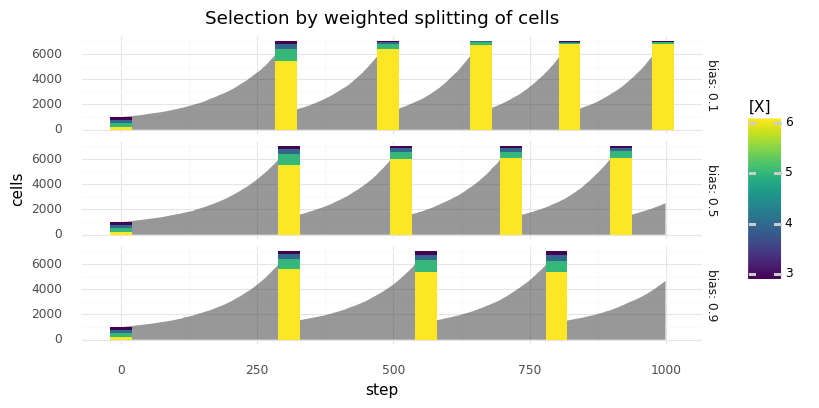

<ggplot: (8740130764254)>

In [40]:
n_cells = 1000
n_steps = 1000
thresh = 7000
split_ratio = 0.2
n_mols = [3, 4, 5, 6]
biases = [.1, .5, .9]

def biased_split(t: torch.Tensor, b: float) -> list[int]:
    m = len(t) / len(t.unique())
    counts = {d.item(): len(t[t == d]) for d in t.unique()}
    samples = {k: (d * (1 - b) + m * b) * split_ratio for k, d in counts.items()}
    new_cells = [[k] * int(d) for k, d in samples.items()]
    return torch.tensor([dd for d in new_cells for dd in d])

records = []
for bias in biases:
    X = torch.cat([torch.ones(int(n_cells / len(n_mols))) * d for d in n_mols])

    kwargs = {"step": 0, "bias": bias}
    for n_mol in n_mols:
        records.append({**kwargs, "[X]": n_mol, "cells": len(X[X == n_mol])})

    for step in range(n_steps):
        kwargs = {"step": step, "bias": bias}
        if len(X) > thresh:
            for n_mol in n_mols:
                records.append({**kwargs, "[X]": n_mol, "cells": len(X[X == n_mol])})
            X = biased_split(X, bias)

        records.append({**kwargs, "[X]": -1, "cells": len(X)})
        
        kidxs = sample(kill(X))
        keep = torch.ones(X.size(), dtype=bool)
        keep[kidxs] = False
        X = X[keep]

        ridxs = sample(replicate(X))
        X = torch.cat([X, X[ridxs].clone()])

df = pd.DataFrame.from_records(records)
df["bias"] = pd.Categorical(df["bias"], categories=biases)

(ggplot(df, aes(x="step", y="cells"))
    + geom_area(data=df[df["[X]"] == -1], alpha=.5)
    + geom_col(aes(fill="[X]", group="[X]"), data=df[df["[X]"] != -1], width=40)
    + facet_grid("bias ~ .", labeller="label_both")
    + theme(figure_size=(8, 4))
    + ggtitle("Selection by weighted splitting of cells"))

## Kinetic Constant Distributions

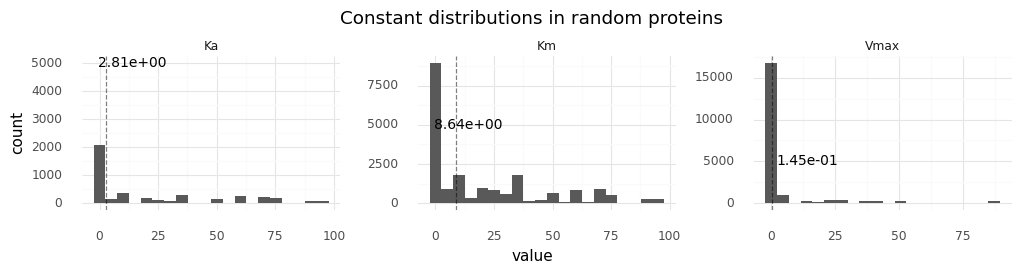

<ggplot: (8793132350461)>

In [3]:
genome_size = 1000
n_cells = 1000

world = ms.World(chemistry=CHEMISTRY)
world.kinetics = ms.Kinetics(molecules=CHEMISTRY.molecules, reactions=CHEMISTRY.reactions)
genomes = [ms.random_genome(s=genome_size) for _ in range(n_cells)]
world.spawn_cells(genomes=genomes)
vmaxs = world.kinetics.Vmax[world.kinetics.Vmax > 0.0].flatten().tolist()
kmfs = world.kinetics.Kmf[world.kinetics.Vmax > 0.0].flatten().tolist()
kmbs = world.kinetics.Kmb[world.kinetics.Vmax > 0.0].flatten().tolist()
Ka = torch.pow(world.kinetics.Kmr, 1 / world.kinetics.A)  # they are powered
kmrs = Ka[world.kinetics.A != 0.0].flatten().tolist()

records=[]
records.extend([{"value": d, "variable": "Vmax"} for d in vmaxs])
records.extend([{"value": min(a, b), "variable": "Km"} for a, b in zip(kmfs, kmbs)])
records.extend([{"value": d, "variable": "Ka"} for d in kmrs])
world.kill_cells(cell_idxs=list(range(world.n_cells)))
df = pd.DataFrame.from_records(records)
avgs = df.groupby("variable")["value"].median().reset_index(name="avg")
avgs["l"] = [f"{d:.2e}" for d in avgs["avg"]]
avgs["x"] = 14
avgs["y"] = 5000

(ggplot(df)
    + geom_histogram(aes(x="value"), bins=20)
    + geom_vline(aes(xintercept="avg"), linetype="dashed", alpha=0.5, data=avgs)
    + geom_text(aes(x="x", y="y", label="l"), data=avgs, size=10)
    + facet_wrap("variable", scales="free")
    + theme(figure_size=(12, 2))
    + theme(subplots_adjust={"wspace": 0.3, "hspace": 0.5})
    + ggtitle("Constant distributions in random proteins"))

## Kinetics Constants

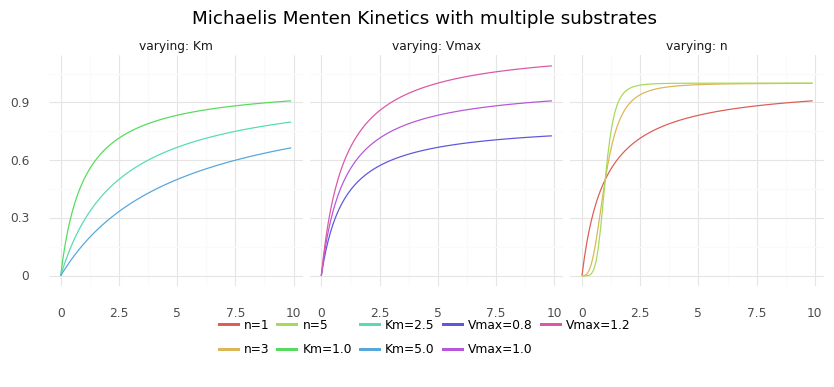

<ggplot: (8742162056883)>

In [24]:
def mm(t: torch.Tensor, v: float, k: float, n: int) -> torch.Tensor:
    return t**n / (k + t**n) * v

X = torch.arange(0, 10, 0.1)

dfs = []
for n in [1, 3, 5]:
    Y = mm(X, 1.0, 1.0, n)
    dfs.append(pd.DataFrame({
        "x": X.tolist(),
        "y": Y.tolist(),
        "value": f"n={n}",
        "varying": "n"
    }))
for k in [1.0, 2.5, 5.0]:
    Y = mm(X, 1.0, k, 1)
    dfs.append(pd.DataFrame({
        "x": X.tolist(),
        "y": Y.tolist(),
        "value": f"Km={k}",
        "varying": "Km"
    }))
for v in [0.8, 1.0, 1.2]:
    Y = mm(X, v, 1.0, 1)
    dfs.append(pd.DataFrame({
        "x": X.tolist(),
        "y": Y.tolist(),
        "value": f"Vmax={v}",
        "varying": "Vmax"
    }))
df = pd.concat(dfs, ignore_index=True)

(ggplot(df, aes(x="x", y="y"))
    + geom_line(aes(color="value"), data=df[df["varying"] == "n"])
    + geom_line(aes(color="value"), data=df[df["varying"] == "Km"])
    + geom_line(aes(color="value"), data=df[df["varying"] == "Vmax"])
    + facet_grid(". ~ varying", labeller="label_both")
    + theme(figure_size=(10, 3), legend_position="bottom", legend_title=element_blank(), axis_title=element_blank())
    + ggtitle("Michaelis Menten Kinetics with multiple substrates"))

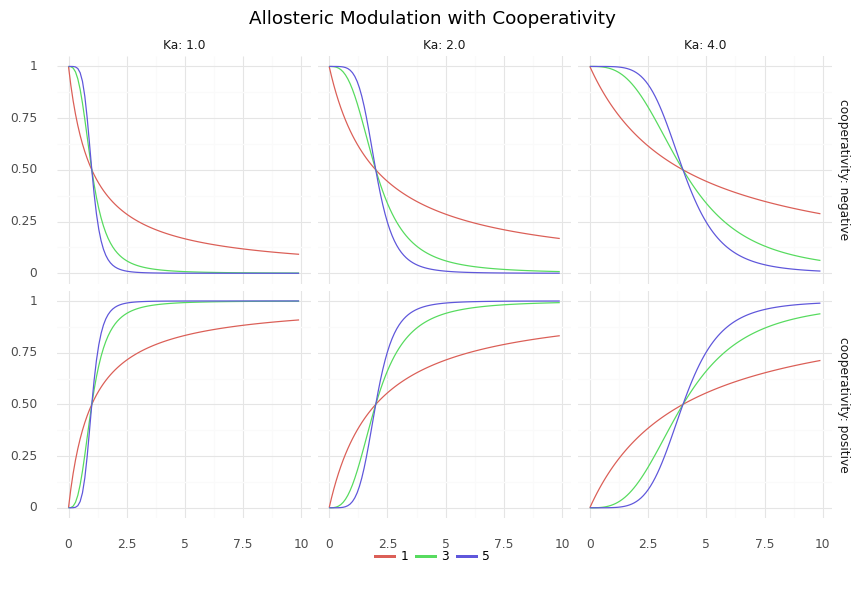

<ggplot: (8742162138119)>

In [25]:
def allo(t: torch.Tensor, k: float, n: int) -> torch.Tensor:
    return t**n / (k**n + t**n)

ns = [1, 3, 5]
ks = [1.0, 2.0, 4.0]
X = torch.arange(0, 10, 0.1)
dfs = []
for n in ns:
    for k in ks:
        for s in ("positive", "negative"):
            Y = allo(X, k, n if s == "positive" else -n)
            dfs.append(pd.DataFrame({
                "x": X.tolist(),
                "y": Y.tolist(),
                "n": n,
                "Ka": k,
                "cooperativity": s
            }))

df = pd.concat(dfs, ignore_index=True)
df.loc[df["y"].isna(), "y"] = 1.0
df["n"] = pd.Categorical(df["n"], categories=ns)
df["Ka"] = pd.Categorical(df["Ka"], categories=ks)

(ggplot(df, aes(x="x", y="y"))
    + geom_line(aes(color="n"))
    + facet_grid("cooperativity ~ Ka", labeller="label_both")
    + theme(figure_size=(10, 6), legend_position="bottom", legend_title=element_blank(), axis_title=element_blank())
    + ggtitle("Allosteric Modulation with Cooperativity"))